In [1]:
import numpy as np
import scipy.io
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from itertools import product
import random
from tqdm import trange

In [19]:
# Set random seed for full reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

### Data Loading & Preparation


In [20]:
# Load data
mat = scipy.io.loadmat('Xtrain.mat')
data = mat['Xtrain'].flatten().reshape(-1, 1) 

# Normalize
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)

# Create window sequences
def create_dataset(series, n_steps):
    X, y = [], []
    for i in range(len(series) - n_steps):
        X.append(series[i:i + n_steps].flatten())
        y.append(series[i + n_steps])
    return np.array(X), np.array(y)

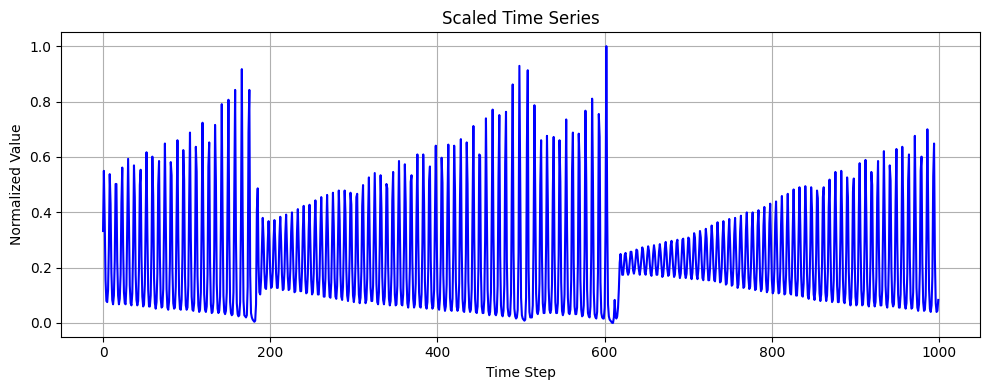

In [21]:
# Plot the scaled data
plt.figure(figsize=(10, 4))
plt.plot(scaled, color='blue')
plt.title('Scaled Time Series')
plt.xlabel('Time Step')
plt.ylabel('Normalized Value')
plt.grid(True)
plt.tight_layout()
plt.show()

### **Model**

In [22]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout_rate=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_sizes[1], 1)
        )

    def forward(self, x):
        return self.net(x)

### **Training Function**


### **Key Components & What They Do**

#### **Parameters**:

* `model`: the neural network to be trained
* `criterion`: loss function (e.g., `nn.MSELoss()`)
* `optimizer`: optimization algorithm (e.g., Adam)
* `X_train_tensor`, `y_train_tensor`: training data (features and targets)
* `X_val_tensor`, `y_val_tensor`: validation data
* `max_epochs`: max number of training epochs (default: 150)
* `patience`: how many epochs to wait for improvement before stopping early (default: 5)
* `min_delta`: minimum improvement in validation loss to be considered significant (default: 1e-4)

### **Training Loop (Epoch-wise)**

For each epoch:

1. **Training Phase**:


2. **Validation Phase**:


3. **Early Stopping Logic**:



### **Returns**:

* `best_loss`: lowest validation loss achieved
* `best_state`: the model weights at the best epoch
* `best_train`: list of training losses per epoch (up to early stop)
* `best_val`: list of validation losses per epoch (up to early stop)




In [23]:
# --- Training Function ---
def train_model(model, criterion, optimizer, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor,
                max_epochs=150, patience=5, min_delta=1e-4):
    best_loss = float('inf')
    epochs_no_improve = 0
    train_losses = []
    val_losses = []

    for epoch in range(max_epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train_tensor)
        loss = criterion(y_pred, y_train_tensor)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_tensor)
            val_loss = criterion(val_pred, y_val_tensor)

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        if val_loss.item() < best_loss - min_delta:
            best_loss = val_loss.item()
            best_state = model.state_dict()
            best_train = train_losses.copy()
            best_val = val_losses.copy()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            break

    return best_loss, best_state, best_train, best_val

### **Hyperparameter Grid Search with Early Stopping**


### **Inside the Loop – For Each Combination**

1. **Data Preparation**:

2. **Tensor Conversion**:

3. **Model Setup**:

4. **Training**:

5. **Results Tracking**:

6. **Best Model Tracking**:

   * If this config achieves a lower validation loss than previous ones, store:

     * `best_val_loss`: the new lowest loss
     * `best_config`: the corresponding hyperparameters
     * `best_model_state`: the best-performing weights
     * `best_X_train`, `best_X_val`, `best_y_train`, `best_y_val`: corresponding datasets
     * `best_train_losses`, `best_val_losses`: for plotting or analysis

In [24]:
n_steps_list = [20, 30, 40, 45, 50, 55, 60, 70, 100, 150]
lrs = [0.005, 0.001 , 0.0005]
hidden_size_sets = [(64, 32), (128, 64)]
dropout_rates = [0.0, 0.1, 0.2]


best_val_loss = float('inf')
best_config = None
best_model_state = None
best_train_losses = []
best_val_losses = []

best_X_train = None
best_X_val = None
best_y_train = None
best_y_val = None

all_results = []

for n_steps, lr, hidden_sizes, drop_out in product(n_steps_list, lrs, hidden_size_sets, dropout_rates):
    print(f"\nTraining with n_steps={n_steps}, lr={lr}, hidden_sizes={hidden_sizes}")

    # Prepare data
    X, y = create_dataset(scaled, n_steps)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, shuffle=False, random_state=SEED)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

    # Init model, loss, optimizer
    model = FeedForwardNN(n_steps, hidden_sizes, drop_out)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Train model
    val_loss, state, train_loss_curve, val_loss_curve = train_model(
        model, criterion, optimizer,
        X_train_tensor, y_train_tensor,
        X_val_tensor, y_val_tensor
    )

    # Store result of this config
    all_results.append({
        'n_steps': n_steps,
        'lr': lr,
        'hidden_sizes': hidden_sizes,
        'drop_out': drop_out,
        'val_loss': val_loss
    })

    # Save best configuration and corresponding data
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_config = (n_steps, lr, hidden_sizes, drop_out)
        best_model_state = state
        best_train_losses = train_loss_curve
        best_val_losses = val_loss_curve
        best_X_train = X_train
        best_X_val = X_val
        best_y_train = y_train
        best_y_val = y_val


Training with n_steps=20, lr=0.005, hidden_sizes=(64, 32)

Training with n_steps=20, lr=0.005, hidden_sizes=(64, 32)

Training with n_steps=20, lr=0.005, hidden_sizes=(64, 32)

Training with n_steps=20, lr=0.005, hidden_sizes=(128, 64)

Training with n_steps=20, lr=0.005, hidden_sizes=(128, 64)

Training with n_steps=20, lr=0.005, hidden_sizes=(128, 64)

Training with n_steps=20, lr=0.001, hidden_sizes=(64, 32)

Training with n_steps=20, lr=0.001, hidden_sizes=(64, 32)

Training with n_steps=20, lr=0.001, hidden_sizes=(64, 32)

Training with n_steps=20, lr=0.001, hidden_sizes=(128, 64)

Training with n_steps=20, lr=0.001, hidden_sizes=(128, 64)

Training with n_steps=20, lr=0.001, hidden_sizes=(128, 64)

Training with n_steps=20, lr=0.0005, hidden_sizes=(64, 32)

Training with n_steps=20, lr=0.0005, hidden_sizes=(64, 32)

Training with n_steps=20, lr=0.0005, hidden_sizes=(64, 32)

Training with n_steps=20, lr=0.0005, hidden_sizes=(128, 64)

Training with n_steps=20, lr=0.0005, hidden_

In [25]:
# Save the best model and config after grid search ends
torch.save({
    'model_state_dict': best_model_state,
    'config': best_config,
    'val_loss': best_val_loss
}, 'best_model.pth')

In [26]:
# ---- Final result ----
print("\nBest Model Found:")
print(f"n_steps={best_config[0]}, lr={best_config[1]}, hidden_sizes={best_config[2]}, drop_out={best_config[3]}")
print(f"Validation Loss: {best_val_loss:.6f}")

# Load best model
best_model = FeedForwardNN(best_config[0], best_config[2], best_config[3])
best_model.load_state_dict(best_model_state)
best_model.eval()


Best Model Found:
n_steps=60, lr=0.005, hidden_sizes=(128, 64), drop_out=0.0
Validation Loss: 0.000149


FeedForwardNN(
  (net): Sequential(
    (0): Linear(in_features=60, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [27]:
df_results = pd.DataFrame(all_results)
df_results['params'] = df_results.apply(
    lambda row: f"n={row['n_steps']}, lr={row['lr']}, h={row['hidden_sizes']}, drop={row['drop_out']}", axis=1
)

# Print sorted results
print("\nAll Config Results (sorted):")
print(df_results.sort_values("val_loss"))


All Config Results (sorted):
     n_steps      lr hidden_sizes  drop_out  val_loss  \
111       60  0.0050    (128, 64)       0.0  0.000149   
57        45  0.0050    (128, 64)       0.0  0.000186   
21        30  0.0050    (128, 64)       0.0  0.000253   
94        55  0.0050    (128, 64)       0.1  0.000282   
39        40  0.0050    (128, 64)       0.0  0.000308   
..       ...     ...          ...       ...       ...   
169      150  0.0010     (64, 32)       0.1  0.034793   
175      150  0.0005     (64, 32)       0.1  0.035643   
159      100  0.0005    (128, 64)       0.0  0.037164   
174      150  0.0005     (64, 32)       0.0  0.038586   
170      150  0.0010     (64, 32)       0.2  0.039145   

                                      params  
111    n=60, lr=0.005, h=(128, 64), drop=0.0  
57     n=45, lr=0.005, h=(128, 64), drop=0.0  
21     n=30, lr=0.005, h=(128, 64), drop=0.0  
94     n=55, lr=0.005, h=(128, 64), drop=0.1  
39     n=40, lr=0.005, h=(128, 64), drop=0.0  
.. 

### **Plot 1: Best Model Loss Evolution Through Epochs**

In [28]:
# Plot 1: Best Model Loss Evolution Through Epochs
def plot_best_model_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Best Model Loss Evolution Through Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()    

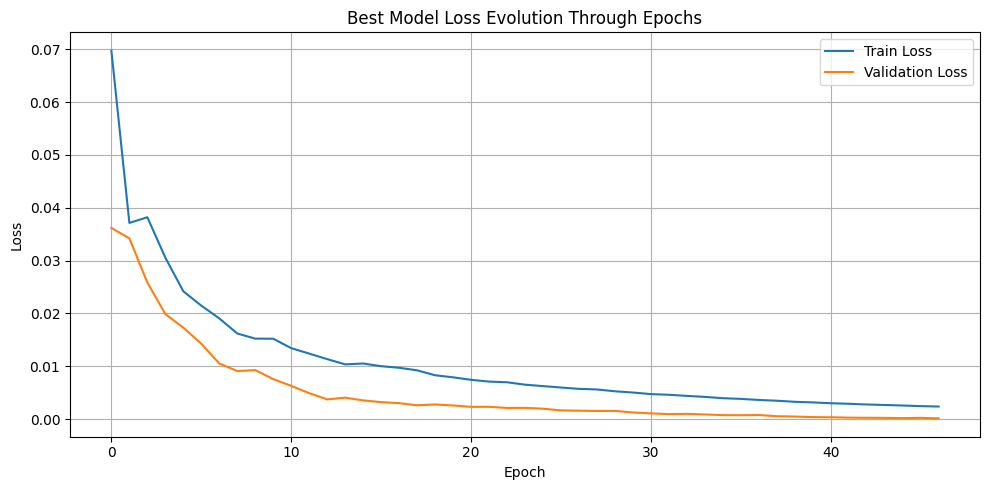

In [436]:
plot_best_model_loss(best_train_losses, best_val_losses)

### **Plot 2: Bar Plot of Validation Loss vs `n_steps` for Best Hyperparameter Settings**


In [29]:
#Plot 2: Bar Plot of Validation Loss vs n_steps for Best Config
def bar_plot_val_loss_vs_n_steps_best_config(all_results):
    df = pd.DataFrame(all_results)

    # Find the best overall config (lowest validation loss)
    best_row = df.loc[df['val_loss'].idxmin()]
    best_lr = best_row['lr']
    best_hidden = best_row['hidden_sizes']
    best_drop = best_row['drop_out']

    # Filter to only rows with best lr and hidden sizes
    filtered_df = df[(df['lr'] == best_lr) & (df['hidden_sizes'] == best_hidden) & (df['drop_out'] == best_drop)]
    filtered_df = filtered_df.sort_values(by='n_steps')

    # Plot
    plt.figure(figsize=(10, 5))
    bars = plt.bar(filtered_df['n_steps'].astype(str), filtered_df['val_loss'])
    plt.xlabel('n_steps')
    plt.ylabel('Validation Loss')
    plt.title(f'Validation Loss by n_steps (best config: lr={best_lr}, h={best_hidden}, drop={best_drop})')
    plt.grid(axis='y')

    # Annotate bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.4f}', 
                 ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

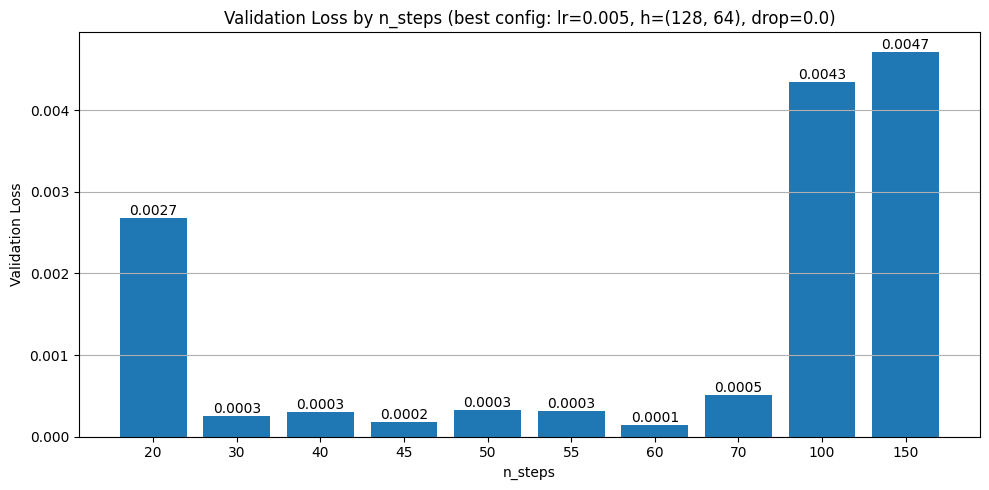

In [30]:
# Call after your search
bar_plot_val_loss_vs_n_steps_best_config(all_results)

### **Validation Forecasting & Visualization**


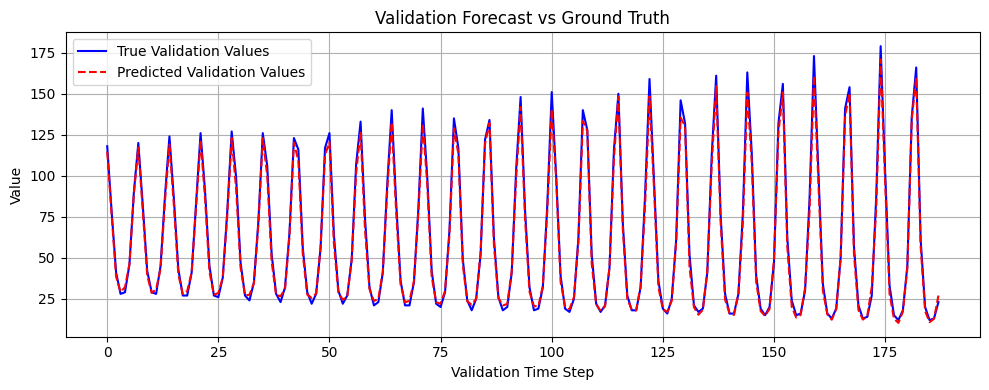

In [31]:
def forecast_validation(model, X_val, y_val, scaler):
    model.eval()
    with torch.no_grad():
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
        preds = model(X_val_tensor).numpy()

    # Inverse scale predictions and actual values
    preds_rescaled = scaler.inverse_transform(preds)
    y_val_rescaled = scaler.inverse_transform(y_val.reshape(-1, 1))
    return preds_rescaled.flatten(), y_val_rescaled.flatten()


# Forecast on validation set
val_predictions, val_true = forecast_validation(best_model, best_X_val, best_y_val, scaler)

# Plot predictions vs true values
plt.figure(figsize=(10, 4))
plt.plot(val_true, label='True Validation Values', color='blue')
plt.plot(val_predictions, label='Predicted Validation Values', color='red', linestyle='--')
plt.title('Validation Forecast vs Ground Truth')
plt.xlabel('Validation Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### **Recursive Forecasting**

### **Output**

* A 1D array of `n_future` predicted values, scaled back to real-world units


In [32]:
# ----  Recursive Forecasting Function ----

def recursive_forecast(model, seed_seq, n_future, scaler):
    model.eval()
    forecast = []
    input_seq = seed_seq.copy()

    for _ in range(n_future):
        input_tensor = torch.tensor(input_seq, dtype=torch.float32).view(1, -1)
        with torch.no_grad():
            next_val = model(input_tensor).item()
        forecast.append(next_val)
        input_seq = input_seq[1:] + [next_val]  # Slide the window

    forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))
    return forecast.flatten()

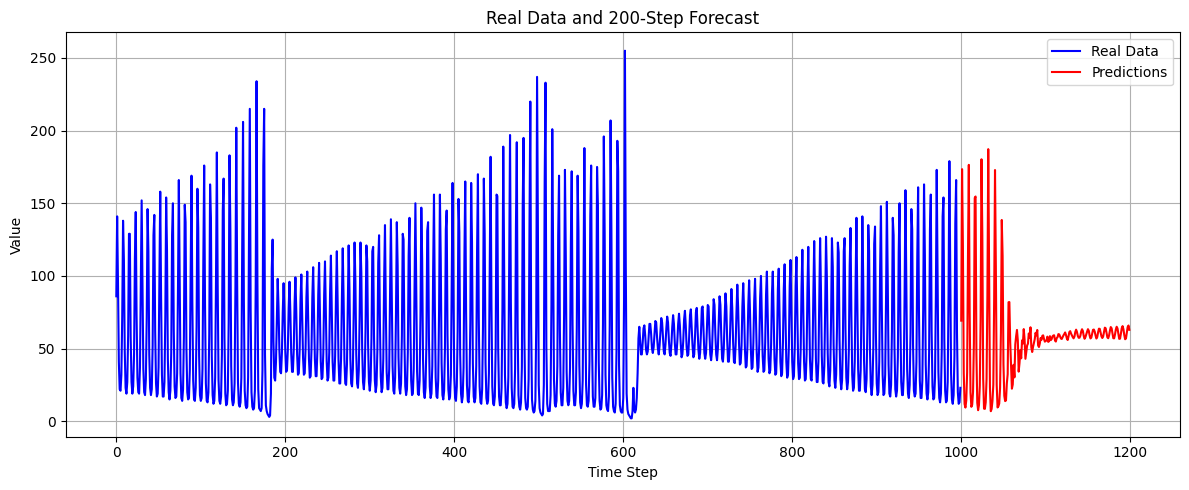

In [33]:
# Use the last real window as seed
best_n_steps = best_config[0] # Number of window size used in the best model
last_window = scaled[-best_n_steps:].flatten().tolist()
n_future = 200  # Number of future steps to predict
future_preds = recursive_forecast(best_model, last_window, n_future, scaler=scaler)

# Inverse transform the full scaled dataset back to original scale for plotting
real_data = scaler.inverse_transform(scaled)

# Create an array combining the original data with predictions
extended = np.concatenate((real_data.flatten(), future_preds))

# Create time axis
time_axis = np.arange(len(extended))
real_axis = np.arange(len(real_data))
pred_axis = np.arange(len(real_data), len(extended))

# Plot
plt.figure(figsize=(12, 5))
#plt.plot(time_axis, extended, label='Extended (Real + Predicted)', linestyle='--', color='gray')
plt.plot(real_axis, real_data, label='Real Data', color='blue')
plt.plot(pred_axis, future_preds, label='Predictions', color='red')
plt.title(f'Real Data and {n_future}-Step Forecast')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()